In [1]:
# Source: https://github.com/oliverguhr/transformer-time-series-prediction

In [2]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import math
import time

import pickle

import warnings
warnings.filterwarnings('ignore')

import copy

In [3]:
from tstransformer import TransTS

In [4]:
def create_in2out_sequences(input_data, window_size):
    in2out_seq = []
    L = len(input_data)
    
    for i in range(L-window_size):
        train_seq = input_data[i:i+window_size]
        train_label = input_data[i+output_window:i+window_size+output_window]
        in2out_seq.append((train_seq ,train_label))
        
        # Shape
        # ---
        # train_seq - (window_size, )
        # train_label - (window_size, )
    
    return torch.FloatTensor(in2out_seq)

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = None

def load_dataset(synthetic=False, dataset=None):
    if synthetic:
        time       = np.arange(0, 400, 0.1)    
        amplitude  = np.sin(time) + np.sin(time*0.05) + \
                     np.sin(time*0.12) * np.random.normal(-0.2, 0.2, len(time))
        return amplitude
    return dataset

def create_dataset(synthetic=False, dataset=None):
    
    values = load_dataset(synthetic, dataset)
    samples = int(0.7 * len(values))
    
    global scaler
        
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    values = scaler.fit_transform(values.reshape(-1, 1)).reshape(-1)
    
    train_data = values[:samples]
    test_data  = values[samples:]
    
    train_data = create_in2out_sequences(train_data, input_window)
    train_data = train_data[:-output_window] # Don't think much. Just did to fix errors.
    
    test_data = create_in2out_sequences(test_data, input_window)
    test_data = test_data[:-output_window] # Don't think much. Just did to fix errors.
    
    return train_data.to(device), test_data.to(device)

In [6]:
def get_batch(source, i, batch_size):
    
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    
    input_ = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    
    # Shape
    # ---
    # input_ - (input_window, batch_size, 1)
    # target - (input_window, batch_size, 1)
    # I know this looks counterintuitive, but bear with me. 
    # URL : https://stackoverflow.com/questions/65451265/pytorch-why-batch-is-the-second-dimension-in-the-default-lstm
    
    return input_, target

In [7]:
def train(train_data):
    
    model.train() 
    
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, targets)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
#             print('| Epoch {:03d} | {:05d}/{:05d} batches | '
#                   'lr {:02.6f} | {:5.2f} ms | '
#                   'loss {:5.5f}'.format(
#                    epoch, 
#                    batch, len(train_data) // batch_size, 
#                    scheduler.get_lr()[0],
#                    elapsed * 1000 / log_interval,
#                    cur_loss))
                  
            total_loss = 0
            start_time = time.time()

In [8]:
def evaluate(model, data_source):
    model.eval()
    
    total_loss = 0.
    eval_batch_size = 1000
        
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = model(data)            
            total_loss += len(data[0])* criterion(output, targets).cpu().item()
    
    return total_loss / len(data_source)

In [9]:
def plot_and_loss(model, data_source, epoch):
    
    model.eval() 
    
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i, 1)
            output = model(data)            
            total_loss += criterion(output, target).item()
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            

    plt.plot(test_result, color="red", label="Test")
    plt.plot(truth, color="blue", label="Truth")
    plt.plot(test_result-truth, color="green", label="Error")
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.legend()
    
    plt.xlabel("Timesteps")
    plt.ylabel("Normalized Values")
    
#     plt.savefig('graph/transformer-epoch%d.png'%epoch)

    plt.show()
    
    return total_loss / len(data_source)

In [10]:
input_window = 1
output_window = 1
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# synthetic = True
# dataset = None

synthetic = False

POLLUTANT = "PM2.5"
mother_dataset = pickle.load(open("./Data/delhi_dataset.pkl", "rb"))

idx = -1
station = mother_dataset[idx]
dataset = station['df'].values

-----------------------------------------------------------------------------------------
| End of epoch 001 | time:  0.07s | valid loss 0.23937
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 002 | time:  0.06s | valid loss 0.17707
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 003 | time:  0.06s | valid loss 0.13231
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 004 | time:  0.06s | valid loss 0.08923
-----------------------------------------------------------------------------------------


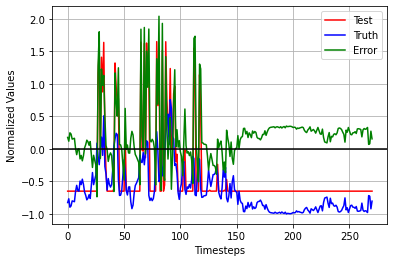

-----------------------------------------------------------------------------------------
| End of epoch 005 | time:  0.41s | valid loss 0.24049
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 006 | time:  0.07s | valid loss 0.06586
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 007 | time:  0.07s | valid loss 0.05771
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 008 | time:  0.06s | valid loss 0.04788
-----------------------------------------------------------------------------------------
------------------------------------------------------------

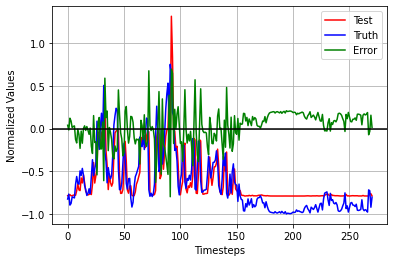

-----------------------------------------------------------------------------------------
| End of epoch 010 | time:  0.40s | valid loss 0.04477
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 011 | time:  0.06s | valid loss 0.05395
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 012 | time:  0.05s | valid loss 0.05188
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 013 | time:  0.05s | valid loss 0.05423
-----------------------------------------------------------------------------------------
------------------------------------------------------------

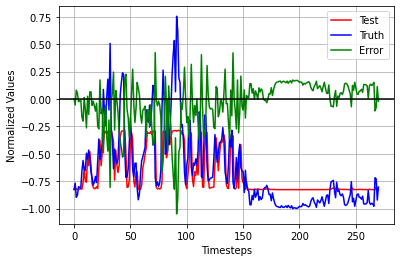

-----------------------------------------------------------------------------------------
| End of epoch 015 | time:  0.41s | valid loss 0.04797
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 016 | time:  0.06s | valid loss 0.04360
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 017 | time:  0.05s | valid loss 0.04400
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 018 | time:  0.05s | valid loss 0.04030
-----------------------------------------------------------------------------------------
------------------------------------------------------------

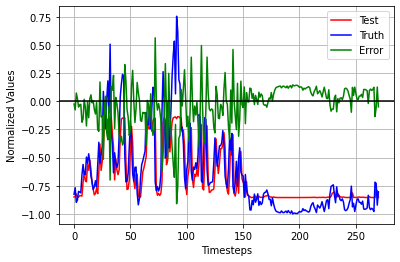

-----------------------------------------------------------------------------------------
| End of epoch 020 | time:  0.41s | valid loss 0.03873
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 021 | time:  0.07s | valid loss 0.03741
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 022 | time:  0.06s | valid loss 0.03655
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 023 | time:  0.07s | valid loss 0.03601
-----------------------------------------------------------------------------------------
------------------------------------------------------------

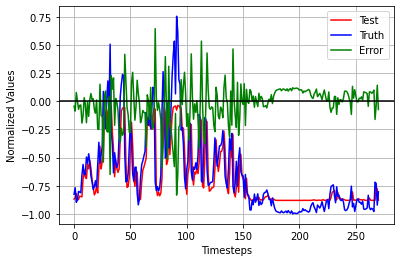

-----------------------------------------------------------------------------------------
| End of epoch 025 | time:  0.40s | valid loss 0.03466
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 026 | time:  0.07s | valid loss 0.03422
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 027 | time:  0.06s | valid loss 0.03687
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 028 | time:  0.06s | valid loss 0.03605
-----------------------------------------------------------------------------------------
------------------------------------------------------------

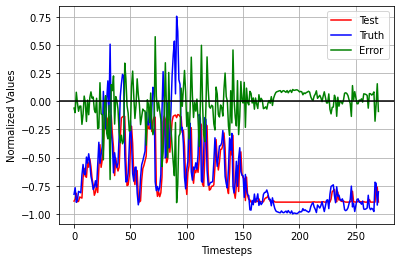

-----------------------------------------------------------------------------------------
| End of epoch 030 | time:  0.40s | valid loss 0.03546
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 031 | time:  0.07s | valid loss 0.03630
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 032 | time:  0.06s | valid loss 0.03489
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 033 | time:  0.06s | valid loss 0.03571
-----------------------------------------------------------------------------------------
------------------------------------------------------------

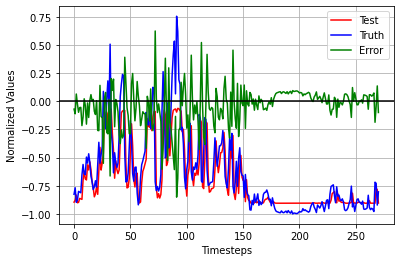

-----------------------------------------------------------------------------------------
| End of epoch 035 | time:  0.40s | valid loss 0.03530
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 036 | time:  0.07s | valid loss 0.03436
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 037 | time:  0.07s | valid loss 0.03509
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 038 | time:  0.06s | valid loss 0.03406
-----------------------------------------------------------------------------------------
------------------------------------------------------------

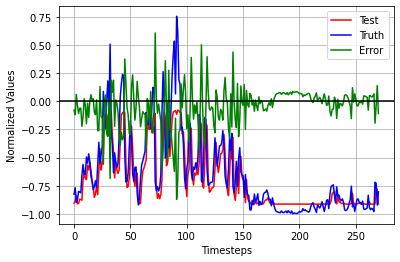

-----------------------------------------------------------------------------------------
| End of epoch 040 | time:  0.44s | valid loss 0.03573
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 041 | time:  0.07s | valid loss 0.03551
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 042 | time:  0.06s | valid loss 0.03563
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 043 | time:  0.05s | valid loss 0.03591
-----------------------------------------------------------------------------------------
------------------------------------------------------------

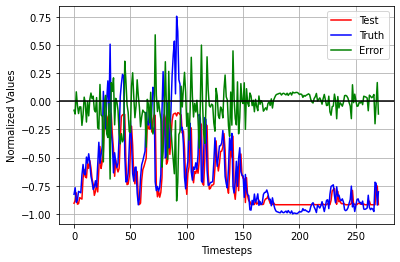

-----------------------------------------------------------------------------------------
| End of epoch 045 | time:  0.39s | valid loss 0.03504
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 046 | time:  0.07s | valid loss 0.03556
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 047 | time:  0.06s | valid loss 0.03501
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 048 | time:  0.06s | valid loss 0.03509
-----------------------------------------------------------------------------------------
------------------------------------------------------------

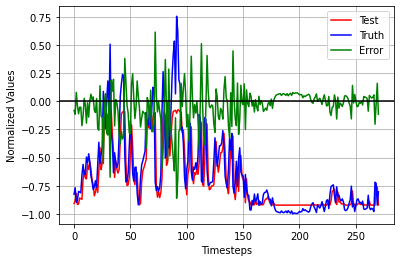

-----------------------------------------------------------------------------------------
| End of epoch 050 | time:  0.39s | valid loss 0.03490
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 051 | time:  0.06s | valid loss 0.03448
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 052 | time:  0.06s | valid loss 0.03460
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 053 | time:  0.06s | valid loss 0.03460
-----------------------------------------------------------------------------------------
------------------------------------------------------------

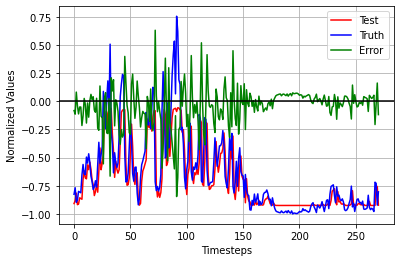

-----------------------------------------------------------------------------------------
| End of epoch 055 | time:  0.39s | valid loss 0.03449
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 056 | time:  0.07s | valid loss 0.03539
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 057 | time:  0.06s | valid loss 0.03521
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| End of epoch 058 | time:  0.06s | valid loss 0.03487
-----------------------------------------------------------------------------------------
Best Model
---
Validation Loss: 0.03406


In [12]:
train_data, val_data = create_dataset(synthetic=synthetic, dataset=dataset)
model = TransTS(input_window).to(device)

criterion = nn.MSELoss()
lr = 0.005 

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

best_val_loss = float("inf")
epochs = 200
best_model = None

early_stop_flag = False
min_val_loss = 1e9
bad_val_loss_ctr = 0

for epoch in range(1, epochs + 1):
    
    if (early_stop_flag):
        break
    
    epoch_start_time = time.time()
    train(train_data)
    
    if(epoch % 5 == 0):
        val_loss = plot_and_loss(model, val_data, epoch)
    else:
        val_loss = evaluate(model, val_data)
   
    print('-' * 89)
    
    print('| End of epoch {:03d} | time: {:5.2f}s | valid loss {:5.5f}'.format(epoch, 
           (time.time() - epoch_start_time), 
           val_loss))
    
    print('-' * 89)

    scheduler.step() 
    
    if (min_val_loss > val_loss):
        best_model = copy.deepcopy(model.state_dict())
        min_val_loss = val_loss
        bad_val_loss_ctr = 0
    else:
        bad_val_loss_ctr += 1
        
    if bad_val_loss_ctr >= 20:
        early_stop_flag = True
        
print("Best Model")
print("---")
print(f"Validation Loss: {min_val_loss:.5f}")

In [13]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [14]:
def get_predictions_df(model, data_source):
    
    model.eval() 
    
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i, 1)
            output = model(data)            
            total_loss += criterion(output, target).item()
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0)
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
    test_result = scaler.inverse_transform(test_result.unsqueeze(-1))
    truth = scaler.inverse_transform(truth.unsqueeze(-1))
    dates = station['df'].index.values[-data_source.shape[0]+1:]
    
    predictions_df = pd.DataFrame(index=dates)
    predictions_df['Actual'] = truth
    predictions_df['Predicted'] = test_result
    
    return predictions_df

def plot_and_loss_final(predictions_df):
    
    fig = plt.figure(figsize=(18, 4))
    ax = fig.gca()

    predictions_df.plot(ax=fig.gca())
          
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.title(f"TSTransformer | {station['city']} - {station['station_id']} | Test Set", fontsize=14)
    plt.grid(ls='--')     
    
#     plt.savefig('graph/transformer-epoch%d.png'%epoch)

    plt.show()

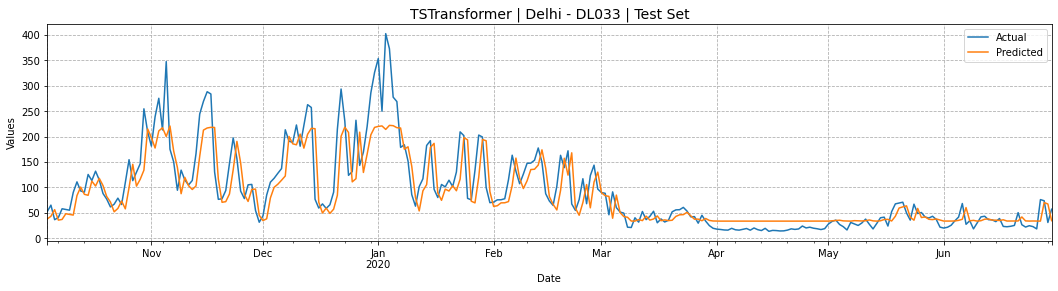

In [15]:
predictions_df = get_predictions_df(model, val_data)
plot_and_loss_final(predictions_df)

In [16]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_test = predictions_df['Actual']
y_pred = predictions_df['Predicted']

score = {
    "r2_score": r2_score(y_test, y_pred),
    "mae": mean_absolute_error(y_test, y_pred), 
    "rmse": np.sqrt(mean_squared_error(y_test, y_pred)),
    "mean": np.mean(y_test)
}

In [17]:
score

{'r2_score': 0.7268764761829787,
 'mae': 27.407154323881375,
 'rmse': 40.96205024342034,
 'mean': 93.50893019228778}